## Download dataset

In [1]:
# https://www.kaggle.com/c/facial-keypoints-detection/data
!wget https://storage.googleapis.com/ai_data_colab2/facial-keypoints-detection.zip \
      -O facial-keypoints-detection.zip
!unzip facial-keypoints-detection.zip
!unzip test.zip
!unzip training.zip

--2021-01-28 03:24:15--  https://storage.googleapis.com/ai_data_colab2/facial-keypoints-detection.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.188.128, 64.233.189.128, 74.125.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.188.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 79999502 (76M) [application/zip]
Saving to: ‘facial-keypoints-detection.zip’

facial-keypoints-de 100%[===================>]  76.29M  89.9MB/s    in 0.8s    

2021-01-28 03:24:16 (89.9 MB/s) - ‘facial-keypoints-detection.zip’ saved [79999502/79999502]

Archive:  facial-keypoints-detection.zip
  inflating: IdLookupTable.csv       
  inflating: SampleSubmission.csv    
  inflating: test.zip                
  inflating: training.zip            
Archive:  test.zip
  inflating: test.csv                
Archive:  training.zip
  inflating: training.csv            


## Import libraries

In [1]:
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split 
from matplotlib import pyplot as plt
import os 

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, BatchNormalization, Dropout, Activation, MaxPool2D, LeakyReLU


## Check the data

In [2]:
IdLookupTable = pd.read_csv('./IdLookupTable.csv')
IdLookupTable.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27124 entries, 0 to 27123
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   RowId        27124 non-null  int64  
 1   ImageId      27124 non-null  int64  
 2   FeatureName  27124 non-null  object 
 3   Location     0 non-null      float64
dtypes: float64(1), int64(2), object(1)
memory usage: 847.8+ KB


In [3]:
IdLookupTable.tail()

,RowId,ImageId,FeatureName,Location
27119,27120,1783,right_eye_center_y,NaN
27120,27121,1783,nose_tip_x,NaN
27121,27122,1783,nose_tip_y,NaN
27122,27123,1783,mouth_center_bottom_lip_x,NaN
27123,27124,1783,mouth_center_bottom_lip_y,NaN


In [4]:
test = pd.read_csv('./test.csv')
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1783 entries, 0 to 1782
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ImageId  1783 non-null   int64 
 1   Image    1783 non-null   object
dtypes: int64(1), object(1)
memory usage: 28.0+ KB


In [6]:
test.head()

,ImageId,Image
0,1,182 183 182 182 180 180 176 169 156 137 124 10...
1,2,76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 4...
2,3,177 176 174 170 169 169 168 166 166 166 161 14...
3,4,176 174 174 175 174 174 176 176 175 171 165 15...
4,5,50 47 44 101 144 149 120 58 48 42 35 35 37 39 ...


In [7]:
training = pd.read_csv('./training.csv')
training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7049 entries, 0 to 7048
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          7039 non-null   float64
 1   left_eye_center_y          7039 non-null   float64
 2   right_eye_center_x         7036 non-null   float64
 3   right_eye_center_y         7036 non-null   float64
 4   left_eye_inner_corner_x    2271 non-null   float64
 5   left_eye_inner_corner_y    2271 non-null   float64
 6   left_eye_outer_corner_x    2267 non-null   float64
 7   left_eye_outer_corner_y    2267 non-null   float64
 8   right_eye_inner_corner_x   2268 non-null   float64
 9   right_eye_inner_corner_y   2268 non-null   float64
 10  right_eye_outer_corner_x   2268 non-null   float64
 11  right_eye_outer_corner_y   2268 non-null   float64
 12  left_eyebrow_inner_end_x   2270 non-null   float64
 13  left_eyebrow_inner_end_y   2270 non-null   float

In [8]:
training.head(2)

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,23.452872,37.389402,56.953263,29.033648,80.227128,32.228138,40.227609,29.002322,16.356379,29.647471,44.420571,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,24.472511,33.144443,53.987404,28.275949,78.634213,30.405923,42.728851,26.146043,16.865362,27.058860,48.206298,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...


In [9]:
training = training.dropna()
#training.fillna(method = 'ffill',inplace = True)

In [10]:
training.shape, type(training)

((2140, 31), pandas.core.frame.DataFrame)

In [11]:
training['Image'] = training['Image'].apply(lambda x: np.fromstring(x, dtype=int, sep=' ').reshape((96,96)))

In [12]:
print(type(training['Image'][0]))
print(training['Image'][0])

<class 'numpy.ndarray'>
[[238 236 237 ... 250 250 250]
 [235 238 236 ... 249 250 251]
 [237 236 237 ... 251 251 250]
 ...
 [186 183 181 ...  52  57  60]
 [189 188 207 ...  61  69  78]
 [191 184 184 ...  70  75  90]]


In [13]:
def get_image_and_dots(df, index):
    image = plt.imshow(df['Image'][index],cmap='gray')
    l = []
    for i in range(1,31,2):
        l.append(plt.plot(df.loc[index][i-1], df.loc[index][i], 'bx'))
        
    return image, l

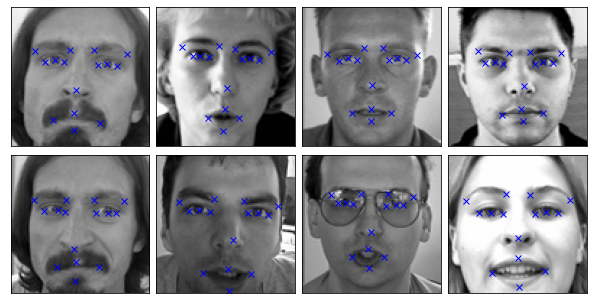

In [14]:
fig = plt.figure(figsize=(8, 4))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, xticks=[], yticks=[])
    get_image_and_dots(training, i)

plt.show()

In [15]:
print(training['Image'])

0       [[238, 236, 237, 238, 240, 240, 239, 241, 241,...
1       [[219, 215, 204, 196, 204, 211, 212, 200, 180,...
2       [[144, 142, 159, 180, 188, 188, 184, 180, 167,...
3       [[193, 192, 193, 194, 194, 194, 193, 192, 168,...
4       [[147, 148, 160, 196, 215, 214, 216, 217, 219,...
                              ...                        
2277    [[191, 191, 191, 190, 189, 185, 184, 120, 54, ...
2278    [[19, 19, 19, 18, 13, 7, 3, 4, 3, 1, 3, 9, 11,...
2281    [[31, 40, 47, 31, 54, 58, 63, 100, 86, 80, 82,...
2282    [[7, 1, 5, 1, 3, 20, 12, 0, 5, 8, 6, 18, 13, 9...
2283    [[68, 19, 19, 23, 19, 26, 23, 16, 8, 15, 9, 9,...
Name: Image, Length: 2140, dtype: object


In [16]:
X_list = []
for i in training['Image']:
  X_list.append(i)

In [17]:
X = np.array(X_list).reshape(training.shape[0],96,96,1)
y = training.drop(['Image'], axis=1)

In [18]:
print(X.shape)
print(y.shape)
print(type(X))
print(type(y))

(2140, 96, 96, 1)
(2140, 30)
<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>


In [19]:
y2 = y.to_numpy()
type(y2), y2.shape

(numpy.ndarray, (2140, 30))

In [24]:
X_train, X_val, y_train, y_val = train_test_split(X, y2, test_size=0.2, random_state=42)

## Model

In [21]:
# Functional API
def feature_extractor(inputs):
    x = tf.keras.layers.Conv2D(16, activation='relu', kernel_size=3, input_shape=(96, 96, 1))(inputs)
    x = tf.keras.layers.AveragePooling2D((2, 2))(x)

    x = tf.keras.layers.Conv2D(32,kernel_size=3,activation='relu')(x)
    x = tf.keras.layers.AveragePooling2D((2, 2))(x)

    x = tf.keras.layers.Conv2D(64,kernel_size=3,activation='relu')(x)
    x = tf.keras.layers.AveragePooling2D((2, 2))(x)

    return x

def dense_layers(inputs):
  x = tf.keras.layers.Flatten()(inputs)
  x = tf.keras.layers.Dense(128, activation='relu')(x)
  return x

def feature_point_regression(inputs):
    bounding_box_regression_output = tf.keras.layers.Dense(30, name = 'feature_points')(inputs)
    return bounding_box_regression_output

inputs = tf.keras.layers.Input(shape=(96, 96, 1,))
feature_cnn = feature_extractor(inputs)
dense_output = dense_layers(feature_cnn)
feature_point_output = feature_point_regression(dense_output)

model = tf.keras.Model(inputs = inputs, outputs = feature_point_output)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 96, 96, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 94, 94, 16)        160       
_________________________________________________________________
average_pooling2d (AveragePo (None, 47, 47, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 45, 45, 32)        4640      
_________________________________________________________________
average_pooling2d_1 (Average (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 64)        18496     
_________________________________________________________________
average_pooling2d_2 (Average (None, 10, 10, 64)        0     

In [22]:
model.compile(optimizer='Adam', 
              loss='mse', 
              metrics=['mae'])

In [25]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=300)

Epoch 1/300
54/54 [==============================] - 3s 12ms/step - loss: 609.1315 - mae: 17.4626 - val_loss: 126.6819 - val_mae: 8.7561
Epoch 2/300
54/54 [==============================] - 0s 7ms/step - loss: 123.9564 - mae: 8.4385 - val_loss: 96.1889 - val_mae: 7.3904
Epoch 3/300
54/54 [==============================] - 0s 7ms/step - loss: 89.8123 - mae: 7.1093 - val_loss: 79.2325 - val_mae: 6.6919
Epoch 4/300
54/54 [==============================] - 0s 7ms/step - loss: 79.4705 - mae: 6.7393 - val_loss: 77.6439 - val_mae: 6.5003
Epoch 5/300
54/54 [==============================] - 0s 7ms/step - loss: 68.2607 - mae: 6.1558 - val_loss: 66.4896 - val_mae: 6.1124
Epoch 6/300
54/54 [==============================] - 0s 8ms/step - loss: 60.8719 - mae: 5.8236 - val_loss: 58.2883 - val_mae: 5.5910
Epoch 7/300
54/54 [==============================] - 0s 8ms/step - loss: 51.3523 - mae: 5.3074 - val_loss: 63.5216 - val_mae: 5.9819
Epoch 8/300
54/54 [==============================] - 0s 8ms/step

In [29]:
score = model.evaluate(X_val, y_val, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
model.save('model.h5')

Test loss: 4.2827677726745605
Test accuracy: 1.3865448236465454


## plot the predicted result with training data

In [35]:
train_predicts = model.predict(X_train)

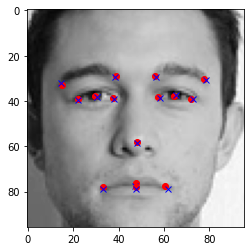

In [38]:
n = 13

xv = X_train[n].reshape((96,96))
plt.imshow(xv,cmap='gray')

for i in range(1,31,2):
    plt.plot(train_predicts[n][i-1], train_predicts[n][i], 'ro')
    plt.plot(y_train[n][i-1], y_train[n][i], 'bx')

plt.show()

## Predict the test data

In [ ]:
test['Image'] = test['Image'].apply(lambda x: np.fromstring(x, dtype=int, sep=' ').reshape((96,96)))

In [ ]:
test.shape, type(test)

In [ ]:
X_list = []
for i in test['Image']:
  X_list.append(i)

In [ ]:
test_X = np.array(X_list).reshape(test.shape[0],96,96,1)
test_res = model.predict(test_X)

Reference: https://towardsdatascience.com/detecting-facial-features-using-deep-learning-2e23c8660a7a  
https://www.kaggle.com/c/facial-keypoints-detection/overview  